# Лабораторная работа № 1
**Вариант:** 9

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors, LinearSegmentedColormap
from matplotlib.markers import MarkerStyle

In [2]:
COLORS = ['red', 'green', 'purple', 'yellow']
    
def plot_history(h, *metrics):
    for metric in metrics:
        print(f"{metric}: {h.history[metric][-1]:.4f}")
    figure = plt.figure(figsize=(6 * len(metrics), 4))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title(metric)
        plt.plot(h.history[metric], '-')
    plt.show()
    
def plot_line(a, b, c):
    plt.axline((-c / a, 0), slope=-a/b)

## Классификация объектов двух классов

In [3]:
data1 = np.array([(-1.1, -4.3), (1.8, -1), (4.8, -1), (1.2, -3.5), (-1.2, -3.4), (2.5, 3.7)])
labels1 = np.array([0, 1, 1, 1, 0, 1])

In [4]:
def plot_two_classes(data, labels, test=False):
    colors = [COLORS[i] for i in labels]
    plt.scatter(data[:, 0], data[:, 1], c=colors, marker=MarkerStyle('o', 'none' if test else 'full'))
    
def plot_two_classes_decision_regions(model, n=100):
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    x = np.linspace(x_min, x_max, n)
    y = np.linspace(y_min, y_max, n)

    xv, yv = np.meshgrid(x, y)
    z = model.predict(np.c_[xv.ravel(), yv.ravel()]).reshape(n, n)

    cmap = LinearSegmentedColormap.from_list('cmap', COLORS[:2])

    plt.contourf(x, y, z, alpha=0.4, cmap=cmap, levels=10)

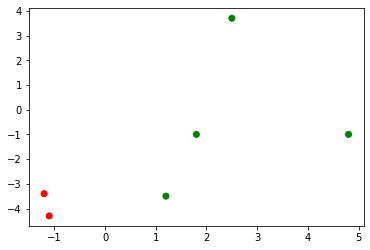

In [5]:
plot_two_classes(data1, labels1)
plt.show()

In [6]:
model1 = keras.models.Sequential([
    keras.layers.Dense(1, input_dim=2, activation='sigmoid')
])

model1.compile(keras.optimizers.Adam(0.1), 'mse', ['mae', 'accuracy'])

hist1 = model1.fit(data1, labels1, batch_size=1, epochs=20, verbose=0)

accuracy: 1.0000
mae: 0.0192


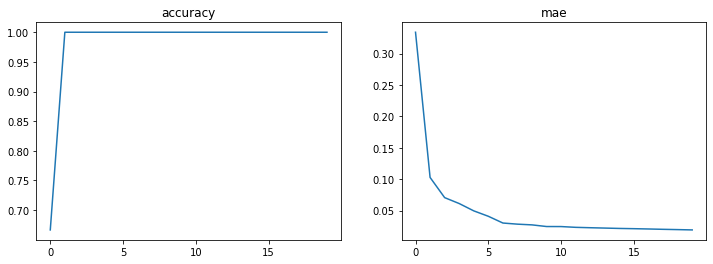

In [7]:
plot_history(hist1, 'accuracy', 'mae')

In [8]:
weights1 = model1.get_weights()

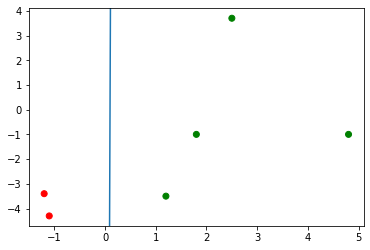

In [9]:
plot_two_classes(data1, labels1)
plot_line(weights1[0][0][0], weights1[0][1][0], weights1[1][0])
plt.show()

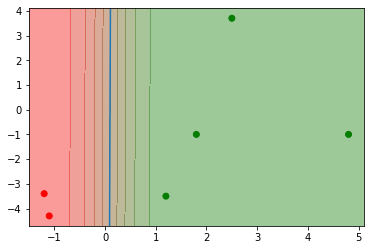

In [10]:
plot_two_classes(data1, labels1)
plot_line(weights1[0][0][0], weights1[0][1][0], weights1[1][0])
plot_two_classes_decision_regions(model1)
plt.show()

### Тестирование

In [11]:
test_size = 3

max_x, max_y = np.max(data1, axis=0)
min_x, min_y = np.min(data1, axis=0)

test_x = (max_x - min_x) * np.random.random(test_size) + min_x
test_y = (max_y - min_y) * np.random.random(test_size) + min_y

test1 = np.stack([test_x, test_y], axis=-1)

In [12]:
test_labels1 = model1.predict(test1)
test_labels1

array([[0.04559571],
       [0.4154906 ],
       [0.9990864 ]], dtype=float32)

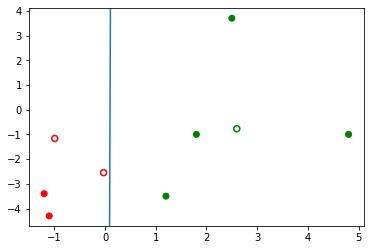

In [13]:
plot_two_classes(data1, labels1)
plot_two_classes(test1, (test_labels1.flat >= 0.5).astype(int), test=True)
plot_line(weights1[0][0][0], weights1[0][1][0], weights1[1][0])

### Линейно неразделимый случай

In [14]:
x = np.linspace(-1.5, 1.3, 10) + (0.6 * np.random.random(10) - 0.3)
y = (x ** 2) + (0.6 * np.random.random(10) - 0.3)
data_nonlin = np.stack((x, y), axis=-1)
labels_nonlin = np.ones((10, ), dtype=int)

x = np.linspace(0, 1, 10) + (0.4 * np.random.random(10) - 0.2)
y = (2 * x + 1) + (0.6 * np.random.random(10) - 0.3)
data_nonlin = np.append(data_nonlin, np.stack((x, y), axis=-1), axis=0)
labels_nonlin = np.append(labels_nonlin, np.zeros((10, ), dtype=int))

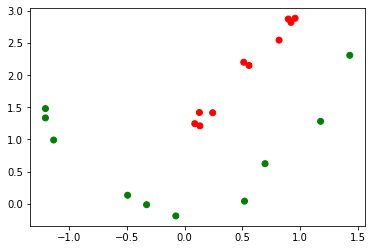

In [15]:
plot_two_classes(data_nonlin, labels_nonlin)

In [16]:
model1_2 = keras.models.Sequential([
    keras.layers.Dense(1, input_dim=2, activation='sigmoid')
])

model1_2.compile(keras.optimizers.Adam(0.1), 'mse', ['mae', 'accuracy'])

hist1_2 = model1_2.fit(data_nonlin, labels_nonlin, batch_size=1, epochs=30, verbose=0)

accuracy: 0.9000
mae: 0.2361


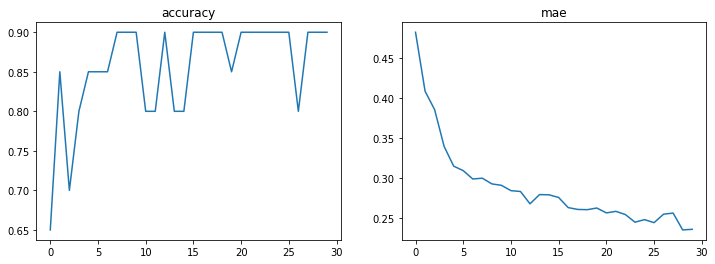

In [17]:
plot_history(hist1_2, 'accuracy', 'mae')

In [18]:
weights1_2 = model1_2.get_weights()

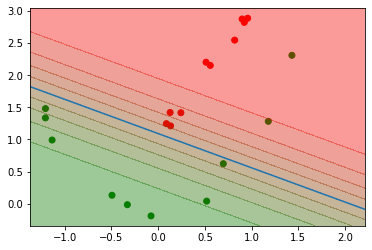

In [19]:
plot_two_classes(data_nonlin, labels_nonlin)
plot_line(weights1_2[0][0][0], weights1_2[0][1][0], weights1_2[1][0])
plot_two_classes_decision_regions(model1_2)
plt.show()

## Классификация объектов четырех классов

In [20]:
data2 = np.array([(4.6, 1.7), (-1, 4.3), (-0.3, -2.7), (-1.1, 2), (0.5, 2.5), (4.9, 4.6), (0.3, 4.6), (-3.9, -4.5)])
labels2 = np.array([(1, 1), (0, 0), (1, 1), (1, 0), (1, 0), (1, 0), (0, 0), (1, 1)])

In [21]:
def plot_four_classes(data, labels, test=False):
    colors = [COLORS[i[0] * 2 + i[1]] for i in labels]
    plt.scatter(data[:, 0], data[:, 1], c=colors, marker=MarkerStyle('o', 'none' if test else 'full'))
    
def accuracy_bin_encoded(labels, pred):
    """Calculates how often predictions match binary encoded labels"""
    correct = 0
    threshold = tf.constant([0.5])
    for i in range(len(labels)):
        if tf.experimental.numpy.all(tf.equal(tf.greater_equal(pred, threshold), tf.cast(labels, tf.bool))):
            correct += 1
    return correct / len(labels)

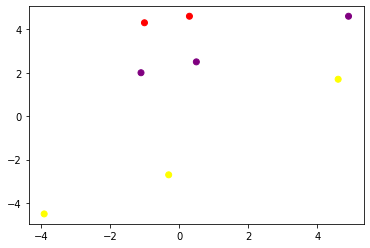

In [22]:
plot_four_classes(data2, labels2)
plt.show()

In [23]:
model2 = keras.models.Sequential([
    keras.layers.Dense(2, input_dim=2, activation='sigmoid')
])

model2.compile(keras.optimizers.Adam(0.01), 'mse', ['mae', accuracy_bin_encoded])

hist2 = model2.fit(data2, labels2, batch_size=1, epochs=100, verbose=0)

accuracy_bin_encoded: 1.0000
mae: 0.1238


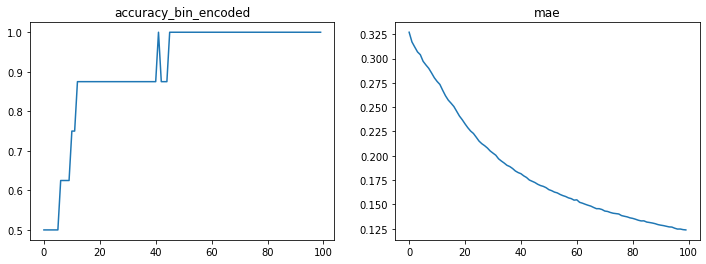

In [24]:
plot_history(hist2, 'accuracy_bin_encoded', 'mae')

In [25]:
weights2 = model2.get_weights()

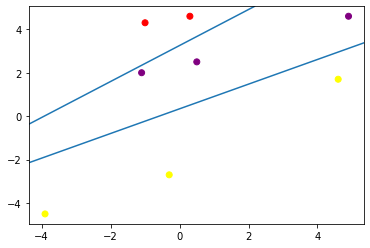

In [26]:
plot_four_classes(data2, labels2)
plot_line(weights2[0][0][0], weights2[0][1][0], weights2[1][0])
plot_line(weights2[0][0][1], weights2[0][1][1], weights2[1][1])
plt.show()

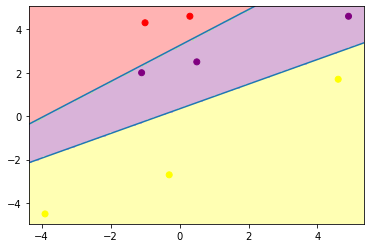

In [27]:
plot_four_classes(data2, labels2)
plot_line(weights2[0][0][0], weights2[0][1][0], weights2[1][0])
plot_line(weights2[0][0][1], weights2[0][1][1], weights2[1][1])

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

n = 100
x = np.linspace(x_min, x_max, n)
y = np.linspace(y_min, y_max, n)

xv, yv = np.meshgrid(x, y)
z = (model2.predict(np.c_[xv.ravel(), yv.ravel()]) > 0.5).astype(int)
z = np.apply_along_axis(lambda x: 2 * x[0] + x[1], 1, z).reshape(n, n)
        
cmap, norm = from_levels_and_colors([-0.5, 0.5, 1.5, 2.5, 3.5], COLORS)

plt.imshow(z, alpha=0.3, extent=(x_min, x_max, y_min, y_max), aspect='auto', origin='lower', cmap=cmap, norm=norm)
plt.show()

### Тестирование

In [34]:
test_size = 5

max_x, max_y = np.max(data2, axis=0)
min_x, min_y = np.min(data2, axis=0)

test_x = (max_x - min_x) * np.random.random(test_size) + min_x
test_y = (max_y - min_y) * np.random.random(test_size) + min_y

test2 = np.stack([test_x, test_y], axis=-1)

In [35]:
test_labels2 = model2.predict(test2)
test_labels2

array([[0.9748095 , 0.9869893 ],
       [0.37566823, 0.01677266],
       [0.7813995 , 0.14751354],
       [0.16402125, 0.00125146],
       [0.9128616 , 0.8421539 ]], dtype=float32)

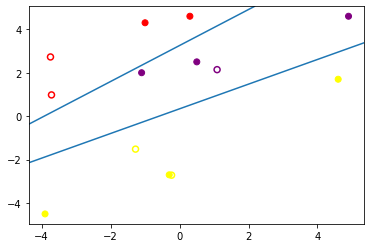

In [36]:
plot_four_classes(data2, labels2)
plot_four_classes(test2, (test_labels2 >= 0.5).astype(int), test=True)
plot_line(weights2[0][0][0], weights2[0][1][0], weights2[1][0])
plot_line(weights2[0][0][1], weights2[0][1][1], weights2[1][1])